In [13]:
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
from collections import defaultdict
import csv
from itertools import permutations
import matplotlib.pyplot as plt
import networkx as nx
import warnings
import numpy as np

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [14]:
df = pd.read_csv('events_2015-2016_pbp.csv')
id_df = pd.read_csv('playerlist.csv')
id_df = id_df[['DISPLAY_FIRST_LAST', 'PERSON_ID']]
players = pd.read_csv('NBA_Players_2016.csv')

In [15]:
players['name'] = players['name'].replace('Goran Dragić', 'Goran Dragic')
players['name'] = players['name'].replace('Dennis Schröder', 'Dennis Schroder')
players['name'] = players['name'].replace('Sasha Vujačić', 'Sasha Vujacic')
players['name'] = players['name'].replace('José Calderón', 'Jose Calderon')
players['name'] = players['name'].replace('Ömer Aşık', 'Omer Asik')
players['name'] = players['name'].replace('Alexis Ajinça', 'Alexis Ajinca')
players['name'] = players['name'].replace('James Ennis', 'James Ennis III')
players['name'] = players['name'].replace('Bojan Bogdanović', 'Bojan Bogdanovic')
players['name'] = players['name'].replace('J.J. Redick', 'JJ Redick')
players['name'] = players['name'].replace('P.J. Hairston', 'PJ Hairston')
players['name'] = players['name'].replace('J.R. Smith', 'JR Smith')

In [ ]:
df['HOME_PLAYER_ID_1'] = df['HOME_PLAYER_ID_1'].map(player_map)
df['HOME_PLAYER_ID_2'] = df['HOME_PLAYER_ID_2'].map(player_map)
df['HOME_PLAYER_ID_3'] = df['HOME_PLAYER_ID_3'].map(player_map)
df['HOME_PLAYER_ID_4'] = df['HOME_PLAYER_ID_4'].map(player_map)
df['HOME_PLAYER_ID_5'] = df['HOME_PLAYER_ID_5'].map(player_map)

df['AWAY_PLAYER_ID_1'] = df['AWAY_PLAYER_ID_1'].map(player_map)
df['AWAY_PLAYER_ID_2'] = df['AWAY_PLAYER_ID_2'].map(player_map)
df['AWAY_PLAYER_ID_3'] = df['AWAY_PLAYER_ID_3'].map(player_map)
df['AWAY_PLAYER_ID_4'] = df['AWAY_PLAYER_ID_4'].map(player_map)
df['AWAY_PLAYER_ID_5'] = df['AWAY_PLAYER_ID_5'].map(player_map)

In [16]:
teams = {'CLE':'Cavaliers', 'TOR':'Raptors', 'MIA':'Heat', 'ATL':'Hawks', 'BOS': 'Celtics', 'CHO':'Hornets',
        'IND':'Pacers', 'DET': 'Pistons', 'CHI':'Bulls', 'WAS':'Wizards','ORL':'Magic', 'NYK':'Knicks',
        'BRK':'Nets', 'GSW':'Warriors', 'SAS':'Spurs', 'OKC':'Thunder', 'LAC':'Clippers', 'POR':'Blazers',
        'DAL':'Mavericks', 'MEM':'Grizzlies', 'HOU':'Rockets', 'UTA':'Jazz', 'SAC':'Kings', 'DEN':'Nuggets', 
        'NOP':'Pelicans', 'MIN':'Timberwolves', 'PHO':'Suns', 'LAL':'Lakers', 'MIL':'Bucks', 'PHI':'76ers'}

In [17]:
player_map = pd.Series(id_df.DISPLAY_FIRST_LAST.values,index=id_df.PERSON_ID).to_dict()

In [18]:
df.columns

Index(['Unnamed: 0', 'EVENTMSGACTIONTYPE', 'EVENTMSGTYPE', 'EVENTNUM',
       'GAME_ID', 'HOMEDESCRIPTION', 'NEUTRALDESCRIPTION', 'PCTIMESTRING',
       'PERIOD', 'PERSON1TYPE',
       ...
       'HOME_PLAYER_ID_1_PLAY_TIME', 'HOME_PLAYER_ID_2_PLAY_TIME',
       'HOME_PLAYER_ID_3_PLAY_TIME', 'HOME_PLAYER_ID_4_PLAY_TIME',
       'HOME_PLAYER_ID_5_PLAY_TIME', 'AWAY_PLAYER_ID_1_PLAY_TIME',
       'AWAY_PLAYER_ID_2_PLAY_TIME', 'AWAY_PLAYER_ID_3_PLAY_TIME',
       'AWAY_PLAYER_ID_4_PLAY_TIME', 'AWAY_PLAYER_ID_5_PLAY_TIME'],
      dtype='object', length=111)

# Single Game Exploration

In [61]:
subset = df.loc[df.GAME_ID == 21500001]
subset = subset[['GAME_ID','HOMEDESCRIPTION', 'VISITORDESCRIPTION','PCTIMESTRING', 'PERIOD', 'HOME_TEAM', 'AWAY_TEAM',
                'HOME_PLAYER_ID_1','HOME_PLAYER_ID_2', 'HOME_PLAYER_ID_3','HOME_PLAYER_ID_4','HOME_PLAYER_ID_5']]
#              ,'AWAY_PLAYER_ID_1','AWAY_PLAYER_ID_2', 'AWAY_PLAYER_ID_3','AWAY_PLAYER_ID_4','AWAY_PLAYER_ID_5']]

In [62]:
subset['PCTIMESTRING'] = subset['PCTIMESTRING'].str.split(":").apply(lambda x: int(x[0])*60 + int(x[1]))

In [63]:
subs = subset[subset['HOMEDESCRIPTION'].shift(-1).str.contains('SUB', na=False) |
       subset['HOMEDESCRIPTION'].str.contains('SUB', na=False)]
test = subs[~subs['HOMEDESCRIPTION'].str.contains('SUB', na=False)]

### Mutual Play Time
- iterate over rows that come *before sub 
- grab 5 playerids and subtract time from quarter standing
- create edgelist between players


In [64]:
edge_list = []

curr_seconds = 720
curr_period = 1
for row in test.itertuples():
    if row.PERIOD > curr_period:
        curr_period = row.PERIOD 
        curr_seconds = 720 
        
    mutual_time = curr_seconds - row.PCTIMESTRING
    for p1 in range(8,13):
        for p2 in range(p1+1, 13):
            mutual_mins = round((curr_seconds - row.PCTIMESTRING)/60, 2)
            edge_list.append([sorted([row[p1], row[p2]])[0], sorted([row[p1], row[p2]])[1] ,mutual_mins])
#             print([sorted([row[p1], row[p2]])[0], sorted([row[p1], row[p2]])[1] ,mutual_mins])
    curr_seconds = row.PCTIMESTRING

In [65]:
edges = pd.DataFrame(edge_list)
edges.columns =['P1', 'P2', 'MutualTime'] 
edges.groupby(['P1','P2']).sum().reset_index()

,P1,P2,MutualTime
0,2594,200757,5.66
1,2594,200794,17.70
2,2594,201143,15.13
3,2594,201168,5.33
4,2594,201952,20.93
5,2594,203118,3.45
6,2594,203145,14.80
7,2594,203471,6.43
8,2594,203488,6.21
9,200757,200794,12.29


In [66]:
edges['P1'] = edges['P1'].apply(lambda x: id_df.loc[id_df['PERSON_ID'] == x].DISPLAY_FIRST_LAST.item())
edges['P2'] = edges['P2'].apply(lambda x: id_df.loc[id_df['PERSON_ID'] == x].DISPLAY_FIRST_LAST.item())

In [67]:
G=nx.from_pandas_edgelist(edges, 'P1', 'P2', ['MutualTime'])

In [68]:
edge,weights = zip(*nx.get_edge_attributes(G,'MutualTime').items())

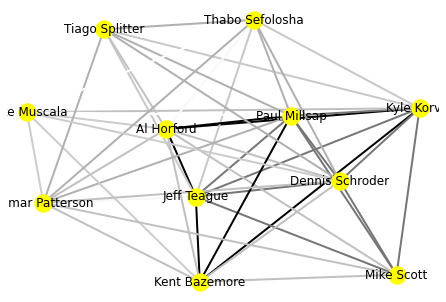

In [69]:
pos = nx.spring_layout(G)
nx.draw(G,with_labels=True, node_color='yellow', edge_color=weights, width=2, edge_cmap=plt.cm.Greys)

# Single Team Exploration

In [85]:
subset = df.loc[df.HOME_TEAM.str.contains('Cavaliers') | df.AWAY_TEAM.str.contains('Cavaliers')]
subset = subset[['GAME_ID','HOMEDESCRIPTION', 'VISITORDESCRIPTION','PCTIMESTRING', 'PERIOD', 'HOME_TEAM', 'AWAY_TEAM',
                'HOME_PLAYER_ID_1','HOME_PLAYER_ID_2', 'HOME_PLAYER_ID_3','HOME_PLAYER_ID_4','HOME_PLAYER_ID_5'
             ,'AWAY_PLAYER_ID_1','AWAY_PLAYER_ID_2', 'AWAY_PLAYER_ID_3','AWAY_PLAYER_ID_4','AWAY_PLAYER_ID_5']]

In [86]:
subset.head(50)

,GAME_ID,HOMEDESCRIPTION,VISITORDESCRIPTION,PCTIMESTRING,PERIOD,HOME_TEAM,AWAY_TEAM,HOME_PLAYER_ID_1,HOME_PLAYER_ID_2,HOME_PLAYER_ID_3,HOME_PLAYER_ID_4,HOME_PLAYER_ID_5,AWAY_PLAYER_ID_1,AWAY_PLAYER_ID_2,AWAY_PLAYER_ID_3,AWAY_PLAYER_ID_4,AWAY_PLAYER_ID_5
468,21500002,NaN,NaN,12:00,1,Bulls,Cavaliers,Derrick Rose,Jimmy Butler,Pau Gasol,Nikola Mirotic,Tony Snell,Mo Williams,JR Smith,Timofey Mozgov,Kevin Love,LeBron James
469,21500002,Jump Ball Gasol vs. Mozgov: Tip to Rose,NaN,12:00,1,Bulls,Cavaliers,Derrick Rose,Jimmy Butler,Pau Gasol,Nikola Mirotic,Tony Snell,Mo Williams,JR Smith,Timofey Mozgov,Kevin Love,LeBron James
470,21500002,MISS Mirotic 3' Driving Finger Roll Layup,NaN,11:35,1,Bulls,Cavaliers,Derrick Rose,Jimmy Butler,Pau Gasol,Nikola Mirotic,Tony Snell,Mo Williams,JR Smith,Timofey Mozgov,Kevin Love,LeBron James
471,21500002,NaN,Love REBOUND (Off:0 Def:1),11:34,1,Bulls,Cavaliers,Derrick Rose,Jimmy Butler,Pau Gasol,Nikola Mirotic,Tony Snell,Mo Williams,JR Smith,Timofey Mozgov,Kevin Love,LeBron James
472,21500002,NaN,Love Dunk (2 PTS) (James 1 AST),11:23,1,Bulls,Cavaliers,Derrick Rose,Jimmy Butler,Pau Gasol,Nikola Mirotic,Tony Snell,Mo Williams,JR Smith,Timofey Mozgov,Kevin Love,LeBron James
473,21500002,MISS Rose 4' Jump Shot,Mozgov BLOCK (1 BLK),11:11,1,Bulls,Cavaliers,Derrick Rose,Jimmy Butler,Pau Gasol,Nikola Mirotic,Tony Snell,Mo Williams,JR Smith,Timofey Mozgov,Kevin Love,LeBron James
474,21500002,NaN,Mozgov REBOUND (Off:0 Def:1),11:09,1,Bulls,Cavaliers,Derrick Rose,Jimmy Butler,Pau Gasol,Nikola Mirotic,Tony Snell,Mo Williams,JR Smith,Timofey Mozgov,Kevin Love,LeBron James
475,21500002,NaN,Williams 21' Jump Shot (2 PTS),11:03,1,Bulls,Cavaliers,Derrick Rose,Jimmy Butler,Pau Gasol,Nikola Mirotic,Tony Snell,Mo Williams,JR Smith,Timofey Mozgov,Kevin Love,LeBron James
476,21500002,MISS Gasol 19' Jump Shot,NaN,10:49,1,Bulls,Cavaliers,Derrick Rose,Jimmy Butler,Pau Gasol,Nikola Mirotic,Tony Snell,Mo Williams,JR Smith,Timofey Mozgov,Kevin Love,LeBron James
477,21500002,NaN,James REBOUND (Off:0 Def:1),10:47,1,Bulls,Cavaliers,Derrick Rose,Jimmy Butler,Pau Gasol,Nikola Mirotic,Tony Snell,Mo Williams,JR Smith,Timofey Mozgov,Kevin Love,LeBron James


In [87]:
len(subset.GAME_ID.unique())

82

In [88]:
players.loc[players.team=='CLE']

,name,team,year,ppg,apg,rpg,3p%,2p%,mp,gp
0,Dahntay Jones,CLE,2016,13.0,2.0,5.0,0.500,0.417,42.0,1
1,LeBron James,CLE,2016,25.3,6.8,7.4,0.309,0.573,35.6,76
2,Kyrie Irving,CLE,2016,19.6,4.7,3.0,0.321,0.502,31.5,53
3,Kevin Love,CLE,2016,16.0,2.4,9.9,0.360,0.467,31.5,77
4,JR Smith,CLE,2016,12.4,1.7,2.8,0.400,0.438,30.7,77
5,Tristan Thompson,CLE,2016,7.8,0.8,9.0,NaN,0.588,27.7,82
6,Matthew Dellavedova,CLE,2016,7.5,4.4,2.1,0.410,0.401,24.6,76
7,Iman Shumpert,CLE,2016,5.8,1.7,3.8,0.295,0.447,24.4,54
8,Mo Williams,CLE,2016,8.2,2.4,1.8,0.353,0.480,18.2,41
9,Richard Jefferson,CLE,2016,5.5,0.8,1.7,0.382,0.554,17.9,74


In [89]:
edge_list = []
nums = 0
for game_id in subset['GAME_ID'].unique():
    boolean = False
    
    subs = subset.loc[df.GAME_ID == game_id]
    name1 = subs.iloc[0]['HOME_PLAYER_ID_1']
    name2 = subs.iloc[0]['HOME_PLAYER_ID_2']
    home_teams1 = list(players.loc[players['name'] == name1].team.values)
    home_teams2 = list(players.loc[players['name'] == name2].team.values)
    for i in range(len(home_teams1)):
        home_teams1[i] = teams[home_teams1[i]]
    for i in range(len(home_teams2)):
        home_teams2[i] = teams[home_teams2[i]]
    boolean = 'Cavaliers' in home_teams1 and 'Cavaliers' in home_teams2
    print(name1, home_teams1, name2, home_teams2,  boolean)
    if boolean:
        print(name1, home_teams1)
        
        new = subs[['HOMEDESCRIPTION', 'PCTIMESTRING', 'PERIOD', 'HOME_TEAM', 'HOME_PLAYER_ID_1',
                         'HOME_PLAYER_ID_2', 'HOME_PLAYER_ID_3', 'HOME_PLAYER_ID_4', 'HOME_PLAYER_ID_5']]
        new['PCTIMESTRING'] = new['PCTIMESTRING'].str.split(":").apply(lambda x: int(x[0])*60 + int(x[1]))
        new = new[new['HOMEDESCRIPTION'].shift(-1).str.contains('SUB', na=False) |
           new['HOMEDESCRIPTION'].str.contains('SUB', na=False)]
        new = new[~new['HOMEDESCRIPTION'].str.contains('SUB', na=False)]
        
        curr_seconds = 720
        curr_period = 1
        for row in new.itertuples():
            if row.PERIOD > curr_period:
                curr_period = row.PERIOD 
                curr_seconds = 720 
            mutual_time = curr_seconds - row.PCTIMESTRING
            for p1 in range(5,9):
                for p2 in range(p1+1, 9):
                    mutual_mins = round((curr_seconds - row.PCTIMESTRING)/60, 2)
                    edge_list.append([sorted([row[p1], row[p2]])[0], sorted([row[p1], row[p2]])[1] ,mutual_mins])
#                     print([sorted([row[p1], row[p2]])[0], sorted([row[p1], row[p2]])[1] ,mutual_mins])
            curr_seconds = row.PCTIMESTRING
        print('\n')

    else:
        new = subs[['VISITORDESCRIPTION', 'PCTIMESTRING', 'PERIOD', 'AWAY_TEAM', 'AWAY_PLAYER_ID_1',
                         'AWAY_PLAYER_ID_2', 'AWAY_PLAYER_ID_3', 'AWAY_PLAYER_ID_4', 'AWAY_PLAYER_ID_5']]
        new['PCTIMESTRING'] = new['PCTIMESTRING'].str.split(":").apply(lambda x: int(x[0])*60 + int(x[1]))
        new = new[new['VISITORDESCRIPTION'].shift(-1).str.contains('SUB', na=False) |
               new['VISITORDESCRIPTION'].str.contains('SUB', na=False)]
        new = new[~new['VISITORDESCRIPTION'].str.contains('SUB', na=False)]

        curr_seconds = 720
        curr_period = 1
        for row in new.itertuples():
            if row.PERIOD > curr_period:
                curr_period = row.PERIOD 
                curr_seconds = 720 
            mutual_time = curr_seconds - row.PCTIMESTRING
            for p1 in range(5,9):
                for p2 in range(p1+1, 9):
                    mutual_mins = round((curr_seconds - row.PCTIMESTRING)/60, 2)
                    edge_list.append([sorted([row[p1], row[p2]])[0], sorted([row[p1], row[p2]])[1] ,mutual_mins])
                    print([sorted([row[p1], row[p2]])[0], sorted([row[p1], row[p2]])[1] ,mutual_mins])
            curr_seconds = row.PCTIMESTRING
    print('\n')

Derrick Rose ['Bulls'] Jimmy Butler ['Bulls'] False
['JR Smith', 'Mo Williams', 4.85]
['Mo Williams', 'Timofey Mozgov', 4.85]
['Kevin Love', 'Mo Williams', 4.85]
['JR Smith', 'Timofey Mozgov', 4.85]
['JR Smith', 'Kevin Love', 4.85]
['Kevin Love', 'Timofey Mozgov', 4.85]
['JR Smith', 'Mo Williams', 1.48]
['Mo Williams', 'Timofey Mozgov', 1.48]
['Kevin Love', 'Mo Williams', 1.48]
['JR Smith', 'Timofey Mozgov', 1.48]
['JR Smith', 'Kevin Love', 1.48]
['Kevin Love', 'Timofey Mozgov', 1.48]
['JR Smith', 'Mo Williams', 1.65]
['Mo Williams', 'Tristan Thompson', 1.65]
['Kevin Love', 'Mo Williams', 1.65]
['JR Smith', 'Tristan Thompson', 1.65]
['JR Smith', 'Kevin Love', 1.65]
['Kevin Love', 'Tristan Thompson', 1.65]
['JR Smith', 'Matthew Dellavedova', 0.13]
['Matthew Dellavedova', 'Tristan Thompson', 0.13]
['Kevin Love', 'Matthew Dellavedova', 0.13]
['JR Smith', 'Tristan Thompson', 0.13]
['JR Smith', 'Kevin Love', 0.13]
['Kevin Love', 'Tristan Thompson', 0.13]
['JR Smith', 'Matthew Dellavedova', 

['Jared Cunningham', 'Matthew Dellavedova', 5.92]
['Matthew Dellavedova', 'Timofey Mozgov', 5.92]
['Kevin Love', 'Matthew Dellavedova', 5.92]
['Jared Cunningham', 'Timofey Mozgov', 5.92]
['Jared Cunningham', 'Kevin Love', 5.92]
['Kevin Love', 'Timofey Mozgov', 5.92]
['Iman Shumpert', 'Matthew Dellavedova', 0.45]
['Matthew Dellavedova', 'Timofey Mozgov', 0.45]
['Kevin Love', 'Matthew Dellavedova', 0.45]
['Iman Shumpert', 'Timofey Mozgov', 0.45]
['Iman Shumpert', 'Kevin Love', 0.45]
['Kevin Love', 'Timofey Mozgov', 0.45]
['Iman Shumpert', 'Matthew Dellavedova', 1.3]
['Matthew Dellavedova', 'Tristan Thompson', 1.3]
['Kevin Love', 'Matthew Dellavedova', 1.3]
['Iman Shumpert', 'Tristan Thompson', 1.3]
['Iman Shumpert', 'Kevin Love', 1.3]
['Kevin Love', 'Tristan Thompson', 1.3]
['Iman Shumpert', 'Matthew Dellavedova', 1.08]
['Matthew Dellavedova', 'Tristan Thompson', 1.08]
['Kevin Love', 'Matthew Dellavedova', 1.08]
['Iman Shumpert', 'Tristan Thompson', 1.08]
['Iman Shumpert', 'Kevin Love', 





Kyrie Irving ['Cavaliers'] JR Smith ['Cavaliers'] True
Kyrie Irving ['Cavaliers']




Kyrie Irving ['Cavaliers'] JR Smith ['Cavaliers'] True
Kyrie Irving ['Cavaliers']




Kyrie Irving ['Cavaliers'] JR Smith ['Cavaliers'] True
Kyrie Irving ['Cavaliers']




Reggie Jackson ['Pistons'] Kentavious Caldwell-Pope ['Pistons'] False
['JR Smith', 'Kyrie Irving', 2.77]
['Kyrie Irving', 'Tristan Thompson', 2.77]
['Kevin Love', 'Kyrie Irving', 2.77]
['JR Smith', 'Tristan Thompson', 2.77]
['JR Smith', 'Kevin Love', 2.77]
['Kevin Love', 'Tristan Thompson', 2.77]
['JR Smith', 'Kyrie Irving', 4.67]
['Kyrie Irving', 'Timofey Mozgov', 4.67]
['Kevin Love', 'Kyrie Irving', 4.67]
['JR Smith', 'Timofey Mozgov', 4.67]
['JR Smith', 'Kevin Love', 4.67]
['Kevin Love', 'Timofey Mozgov', 4.67]
['JR Smith', 'Matthew Dellavedova', 2.25]
['Matthew Dellavedova', 'Timofey Mozgov', 2.25]
['Kevin Love', 'Matthew Dellavedova', 2.25]
['JR Smith', 'Timofey Mozgov', 2.25]
['JR Smith', 'Kevin Love', 2.25]
['Kevin Love',





Brandon Jennings ['Pistons', 'Magic'] Victor Oladipo ['Magic'] False
['JR Smith', 'Kyrie Irving', 7.93]
['Kyrie Irving', 'Timofey Mozgov', 7.93]
['Kevin Love', 'Kyrie Irving', 7.93]
['JR Smith', 'Timofey Mozgov', 7.93]
['JR Smith', 'Kevin Love', 7.93]
['Kevin Love', 'Timofey Mozgov', 7.93]
['JR Smith', 'Kyrie Irving', 0.93]
['Channing Frye', 'Kyrie Irving', 0.93]
['Kyrie Irving', 'Tristan Thompson', 0.93]
['Channing Frye', 'JR Smith', 0.93]
['JR Smith', 'Tristan Thompson', 0.93]
['Channing Frye', 'Tristan Thompson', 0.93]
['Matthew Dellavedova', 'Richard Jefferson', 1.47]
['Iman Shumpert', 'Richard Jefferson', 1.47]
['Channing Frye', 'Richard Jefferson', 1.47]
['Iman Shumpert', 'Matthew Dellavedova', 1.47]
['Channing Frye', 'Matthew Dellavedova', 1.47]
['Channing Frye', 'Iman Shumpert', 1.47]
['Kyrie Irving', 'Richard Jefferson', 0.8]
['Iman Shumpert', 'Richard Jefferson', 0.8]
['Channing Frye', 'Richard Jefferson', 0.8]
['Iman Shumpert', 'Kyrie Irving', 0.8]
['Channing Frye', 'Kyr

In [90]:
edges = pd.DataFrame(edge_list)
edges.columns =['P1', 'P2', 'MutualTime'] 
edges = edges.groupby(['P1','P2']).sum().reset_index()

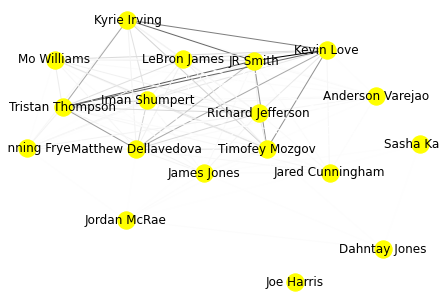

In [92]:
G=nx.from_pandas_edgelist(edges, 'P1', 'P2', ['MutualTime'])
edge,weights = zip(*nx.get_edge_attributes(G,'MutualTime').items())
pos = nx.spring_layout(G)
nx.draw(G,with_labels=True, node_color='yellow', edge_color=weights, width=1, edge_cmap=plt.cm.Greys)

# Creating Script
- Substitute first line (Team Mascot)
- Substitute boolean variable

In [22]:
def create_network(mascot):
    subset = df.loc[df.HOME_TEAM.str.contains(mascot) | df.AWAY_TEAM.str.contains(mascot)]
    subset = subset[['GAME_ID','HOMEDESCRIPTION', 'VISITORDESCRIPTION','PCTIMESTRING', 'PERIOD', 'HOME_TEAM', 'AWAY_TEAM',
                'HOME_PLAYER_ID_1','HOME_PLAYER_ID_2', 'HOME_PLAYER_ID_3','HOME_PLAYER_ID_4','HOME_PLAYER_ID_5',
                'AWAY_PLAYER_ID_1','AWAY_PLAYER_ID_2', 'AWAY_PLAYER_ID_3','AWAY_PLAYER_ID_4','AWAY_PLAYER_ID_5']]
    
    edge_list = []
    nums = 0
    for game_id in subset['GAME_ID'].unique():
        boolean = False

        subs = subset.loc[df.GAME_ID == game_id]
        name1 = subs.iloc[0]['HOME_PLAYER_ID_1']
        name2 = subs.iloc[0]['HOME_PLAYER_ID_2']
        home_teams1 = list(players.loc[players.name == name1].team.values)
        home_teams2 = list(players.loc[players.name == name2].team.values)
        for i in range(len(home_teams1)):
            home_teams1[i] = teams[home_teams1[i]]
        for i in range(len(home_teams2)):
            home_teams2[i] = teams[home_teams2[i]]
#         print(name1, home_teams1)
        boolean = mascot in home_teams1 and mascot in home_teams2
        
        if boolean:
            new = subs[['HOMEDESCRIPTION', 'PCTIMESTRING', 'PERIOD', 'HOME_TEAM', 'HOME_PLAYER_ID_1',
                             'HOME_PLAYER_ID_2', 'HOME_PLAYER_ID_3', 'HOME_PLAYER_ID_4', 'HOME_PLAYER_ID_5']]
            new['PCTIMESTRING'] = new['PCTIMESTRING'].str.split(":").apply(lambda x: int(x[0])*60 + int(x[1]))
            new = new[new['HOMEDESCRIPTION'].shift(-1).str.contains('SUB', na=False) |
               new['HOMEDESCRIPTION'].str.contains('SUB', na=False)]
            new = new[~new['HOMEDESCRIPTION'].str.contains('SUB', na=False)]

            curr_seconds = 720
            curr_period = 1
            for row in new.itertuples():
                if row.PERIOD > curr_period:
                    curr_period = row.PERIOD 
                    curr_seconds = 720 
                mutual_time = curr_seconds - row.PCTIMESTRING
                for p1 in range(5,9):
                    for p2 in range(p1+1, 9):
                        mutual_mins = round((curr_seconds - row.PCTIMESTRING)/60, 2)
                        edge_list.append([sorted([row[p1], row[p2]])[0], sorted([row[p1], row[p2]])[1] ,mutual_mins])
                curr_seconds = row.PCTIMESTRING

        else:
            new = subs[['VISITORDESCRIPTION', 'PCTIMESTRING', 'PERIOD', 'AWAY_TEAM', 'AWAY_PLAYER_ID_1',
                             'AWAY_PLAYER_ID_2', 'AWAY_PLAYER_ID_3', 'AWAY_PLAYER_ID_4', 'AWAY_PLAYER_ID_5']]
            new['PCTIMESTRING'] = new['PCTIMESTRING'].str.split(":").apply(lambda x: int(x[0])*60 + int(x[1]))
            new = new[new['VISITORDESCRIPTION'].shift(-1).str.contains('SUB', na=False) |
                   new['VISITORDESCRIPTION'].str.contains('SUB', na=False)]
            new = new[~new['VISITORDESCRIPTION'].str.contains('SUB', na=False)]

            curr_seconds = 720
            curr_period = 1
            for row in new.itertuples():
                if row.PERIOD > curr_period:
                    curr_period = row.PERIOD 
                    curr_seconds = 720 
                mutual_time = curr_seconds - row.PCTIMESTRING
                for p1 in range(5,9):
                    for p2 in range(p1+1, 9):
                        mutual_mins = round((curr_seconds - row.PCTIMESTRING)/60, 2)
                        edge_list.append([sorted([row[p1], row[p2]])[0], sorted([row[p1], row[p2]])[1] ,mutual_mins])
                curr_seconds = row.PCTIMESTRING
    edges = pd.DataFrame(edge_list)
    edges.columns =['P1', 'P2', 'MutualTime'] 
    edges = edges.groupby(['P1','P2']).sum().reset_index()
    edgeList = edges.values.tolist()
#     G=nx.from_pandas_edgelist(edges, 'P1', 'P2', ['MutualTime'])
#     A = networkx.adjacency_matrix(G).A
#     edge,weights = zip(*nx.get_edge_attributes(G,'MutualTime').items())
    
    return edgeList


### 2016 Edges

In [23]:
edges = []
for i in teams.values():
    team_edge = create_network(i)
    edges.append(team_edge)

In [24]:
G = nx.Graph()
for team in range(len(edges)):
    for player_edge in range(len(edges[team])):
        G.add_edge(edges[team][player_edge][0], edges[team][player_edge][1], weight=edges[team][player_edge][2])

In [25]:
edge,weights = zip(*nx.get_edge_attributes(G,'weight').items())

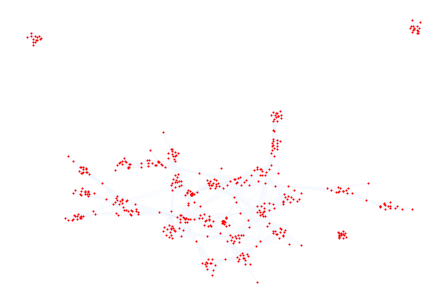

In [26]:
layout = nx.spring_layout(G)
nx.draw(G,with_labels=False, node_color='Red', edge_cmap=plt.cm.Blues, edge_color=weights, width=0.75, node_size=1)
# plt.savefig("2016_graph.png", dpi=750)

In [27]:
A = nx.adjacency_matrix(G).A

In [29]:
np.set_printoptions(threshold=np.inf)

In [33]:
len(A)

469

### Other year Datasets

In [72]:
import io

In [73]:
# requests.get('https://eightthirtyfour.com/data', verify=False).content

In [82]:
URL = 'https://eightthirtyfour.com/nba/pbp/events_2016-2017_pbp.csv'
# URL = 'https://eightthirtyfour.com/nba/pbp/events_{}-{}_pbp.csv'

In [83]:
r = requests.get(URL, verify=False).content

In [84]:
c=pd.read_csv(io.StringIO(r.decode('utf-8')))

In [85]:
c.head()

,Unnamed: 0,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESTRING,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ABBREVIATION,PLAYER1_TEAM_CITY,PLAYER1_TEAM_ID,PLAYER1_TEAM_NICKNAME,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ABBREVIATION,PLAYER2_TEAM_CITY,PLAYER2_TEAM_ID,PLAYER2_TEAM_NICKNAME,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING,HOME_TEAM,AWAY_TEAM,HOME_SCORE,AWAY_SCORE,TIME,TEAM,TYPE,SUB_TYPE,ASSIST_PLAYER_ID,ASSIST_COUNT,BLOCK_PLAYER_ID,BLOCK_COUNT,REBOUND_PLAYER_ID,REBOUND_TEAM,REBOUND_OFFENSIVE_COUNT,REBOUND_DEFENSIVE_COUNT,JUMP_BALL_HOME_PLAYER_ID,JUMP_BALL_AWAY_PLAYER_ID,JUMP_BALL_RETRIEVED_PLAYER_ID,SUB_ENTERED_PLAYER_ID,SUB_LEAVING_PLAYER_ID,FREE_THROW_PLAYER_ID,FREE_THROW_NUM,FREE_THROW_TOTAL,FREE_THROW_MADE,FOULED_BY_PLAYER_ID,DRAWN_FOUL_PLAYER_ID,FOUL_COUNT,TEAM_FOUL_COUNT,FOUL_TYPE,TECHNICAL_PLAYER_ID,DOUBLE_TECHNICAL_PLAYER_ID_1,DOUBLE_TECHNICAL_PLAYER_ID_2,DOUBLE_PERSONAL_PLAYER_ID_1,DOUBLE_PERSONAL_PLAYER_ID_2,DOUBLE_PERSONAL_FOUL_COUNT_1,DOUBLE_PERSONAL_FOUL_COUNT_2,COACH_TECHNICAL,SHOT_PLAYER_ID,POINTS_SCORED,TOTAL_POINTS_SCORED,SHOT_MADE,SHOT_TYPE,STEAL_PLAYER_ID,STEAL_COUNT,TURNOVER_PLAYER_ID,TURNOVER_COUNT,TEAM_TURNOVER_COUNT,TURNOVER_TYPE,POSSESSION_ID,PERIOD_START,PERIOD_END,TIMEOUT_TYPE,VIOLATION,VIOLATION_PLAYER_ID,EJECTION,EJECTION_PLAYER_ID,HOME_PLAYER_ID_1,HOME_PLAYER_ID_2,HOME_PLAYER_ID_3,HOME_PLAYER_ID_4,HOME_PLAYER_ID_5,AWAY_PLAYER_ID_1,AWAY_PLAYER_ID_2,AWAY_PLAYER_ID_3,AWAY_PLAYER_ID_4,AWAY_PLAYER_ID_5,HOME_PLAYER_ID_1_PLAY_TIME,HOME_PLAYER_ID_2_PLAY_TIME,HOME_PLAYER_ID_3_PLAY_TIME,HOME_PLAYER_ID_4_PLAY_TIME,HOME_PLAYER_ID_5_PLAY_TIME,AWAY_PLAYER_ID_1_PLAY_TIME,AWAY_PLAYER_ID_2_PLAY_TIME,AWAY_PLAYER_ID_3_PLAY_TIME,AWAY_PLAYER_ID_4_PLAY_TIME,AWAY_PLAYER_ID_5_PLAY_TIME
0,0,0,12,0,21600256,NaN,NaN,12:00,1,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7:42 PM,Celtics,Heat,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,201609,203585,202355,202682,202337,202738,202340,203092,101161,203109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,10,1,21600256,Jump Ball Whiteside vs. Johnson: Tip to Zeller,NaN,12:00,1,4.0,5,5,202355,Hassan Whiteside,MIA,Miami,1.610613e+09,Heat,101161,Amir Johnson,BOS,Boston,1.610613e+09,Celtics,203092,Tyler Zeller,BOS,Boston,1.610613e+09,Celtics,NaN,NaN,NaN,7:42 PM,Celtics,Heat,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202355.0,101161.0,203092.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201609,203585,202355,202682,202337,202738,202340,203092,101161,203109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,71,2,2,21600256,NaN,NaN,11:38,1,5.0,0,0,202340,Avery Bradley,BOS,Boston,1.610613e+09,Celtics,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MISS Bradley 2' Finger Roll Layup,7:42 PM,Celtics,Heat,0,0,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202340.0,NaN,NaN,False,Layup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201609,203585,202355,202682,202337,202738,202340,203092,101161,203109,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0
3,3,0,4,3,21600256,Williams REBOUND (Off:0 Def:1),NaN,11:37,1,4.0,0,0,202682,Derrick Williams,MIA,Miami,1.610613e+09,Heat,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7:42 PM,Celtics,Heat,0,0,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202682.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201609,203585,202355,202682,202337

In [78]:
new = 'https://eightthirtyfour.com/nba/pbp/events_{}-{}_pbp.csv'

In [80]:
new.format('2016', '2017')

'https://eightthirtyfour.com/nba/pbp/events_2016-2017_pbp.csv'

### Need to create feature data

In [ ]:
def build_feats(data_graph, edges_label,):
        data = data_graph
        edges = edges_label
        #this means we have data and edges
        labels, nodes, X, N, F = parse_data(data)
        edge_list = parse_edges(edges)

        train_idx, val_idx, test_idx = limit_data(labels)

        train_mask = np.zeros((N,),dtype=bool)
        train_mask[train_idx] = True

        val_mask = np.zeros((N,),dtype=bool)
        val_mask[val_idx] = True

        test_mask = np.zeros((N,),dtype=bool)
        test_mask[test_idx] = True

        labels_encoded, classes = encode_label(labels)

        A = build_adj(nodes, edge_list)

        return A, F, N, X, train_mask, val_mask, labels_encoded, classes

In [8]:
with open ('NBA_Players_2016.csv', 'r') as nodecsv:
    nodereader = csv.reader(nodecsv)
    nodes = [n for n in nodereader][1:]

In [9]:
node_names = [n[0] for n in nodes]

In [12]:
warriors = create_network("Warriors")

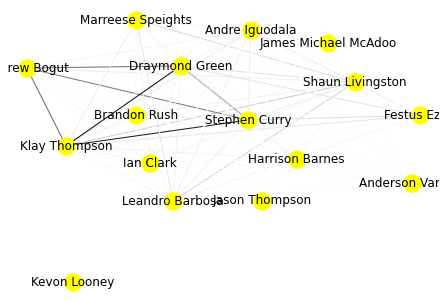

In [13]:
G= warriors
edge,weights = zip(*nx.get_edge_attributes(G,'MutualTime').items())
pos = nx.spring_layout(G)
nx.draw(G,with_labels=True, node_color='yellow', edge_color=weights, width=1, edge_cmap=plt.cm.Greys)

In [25]:
team_dict = {}
year_dict = {}
ppg_dict = {}
apg_dict = {}
rpg_dict = {}
three_point_percentage_dict = {}
two_point_percentage_dict = {}
mp_dict = {}
gp_dict = {}

for node in nodes:
    team_dict[node[0]] = node[1]
    year_dict[node[0]] = node[2]
    ppg_dict[node[0]] = node[3]
    apg_dict[node[0]] = node[4]
    rpg_dict[node[0]] = node[5]
    three_point_percentage_dict[node[0]] = node[6]
    two_point_percentage_dict[node[0]] = node[7]
    mp_dict[node[0]] = node[8]
    gp_dict[node[0]] = node[9]
    
nx.set_node_attributes(warriors, team_dict, 'team')
nx.set_node_attributes(warriors, year_dict, 'year')
nx.set_node_attributes(warriors, ppg_dict, 'ppg')
nx.set_node_attributes(warriors, apg_dict, 'apg')
nx.set_node_attributes(warriors, rpg_dict, 'rpg')
nx.set_node_attributes(warriors, three_point_percentage_dict, '3P%')
nx.set_node_attributes(warriors, two_point_percentage_dict, '2P%')
nx.set_node_attributes(warriors, mp_dict, 'mp')
nx.set_node_attributes(warriors, gp_dict, 'gp')

In [26]:
for n in warriors.nodes():
    try:
#         print(n, warriors.nodes[n]['ppg'], warriors.nodes[n]['apg'], warriors.nodes[n]['rpg'] )
        print(n, warriors.nodes[n])
    except:
        pass

Leandro Barbosa {'team': 'GSW', 'year': '2016', 'ppg': '6.4', 'apg': '1.2', 'rpg': '1.7', '3P%': '.355', '2P%': '.508', 'mp': '15.9', 'gp': '68'}
Shaun Livingston {'team': 'GSW', 'year': '2016', 'ppg': '6.3', 'apg': '3.0', 'rpg': '2.2', '3P%': '.167', '2P%': '.548', 'mp': '19.5', 'gp': '78'}
Andre Iguodala {'team': 'GSW', 'year': '2016', 'ppg': '7.0', 'apg': '3.4', 'rpg': '4.0', '3P%': '.351', '2P%': '.570', 'mp': '26.6', 'gp': '65'}
Anderson Varejao {}
Andrew Bogut {'team': 'GSW', 'year': '2016', 'ppg': '5.4', 'apg': '2.3', 'rpg': '7.0', '3P%': '1.000', '2P%': '.626', 'mp': '20.7', 'gp': '70'}
Jason Thompson {'team': 'GSW', 'year': '2016', 'ppg': '2.1', 'apg': '0.7', 'rpg': '1.9', '3P%': '', '2P%': '.476', 'mp': '6.4', 'gp': '28'}
Brandon Rush {'team': 'GSW', 'year': '2016', 'ppg': '4.2', 'apg': '0.8', 'rpg': '2.5', '3P%': '.414', '2P%': '.447', 'mp': '14.7', 'gp': '72'}
Marreese Speights {'team': 'GSW', 'year': '2016', 'ppg': '7.1', 'apg': '0.8', 'rpg': '3.3', '3P%': '.387', '2P%': '

In [20]:
print(nx.info(warriors))

Name: 
Type: Graph
Number of nodes: 16
Number of edges: 107
Average degree:  13.3750


### GCN

### GraphSage